In [52]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import os
from statistics import mean

plt.close('all')

In [53]:
aps = [0.512, 0.344, 0.5, 0.249, 0.497, 0.255, 0.494, 0.225, 0.49, 0.287, 0.484, 0.369, 0.481, 0.21, 0.476, 0.269,
       0.473, 0.302, 0.468, 0.329, 0.465, 0.229, 0.458, 0.298, 0.452, 0.214, 0.449, 0.227, 0.443]
aps_t = [0.375, 0.257, 0.36, 0.241, 0.35, 0.144, 0.337, 0.135, 0.316, 0.179, 0.312, 0.126, 0.307, 0.055, 0.296, 0.140, 
        0.29, 0.176, 0.282, 0.082, 0.274, 0.116, 0.266, 0.105, 0.260, 0.102, 0.251, 0.099, 0.237]
mod_aps = [0.344, 0.33, 0.316, 0.306, 0.282, 0.277, 0.272, 0.264, 0.256, 0.249, 0.243, 0.231, 0.225, 0.218, 0.205]
per_params = [0, 23.76, 39, 49.2, 56.31, 63.1, 67.56, 71.92, 75.18, 77.62, 80.18, 82.63, 84.74, 86.26, 87.51]
per_flops = [0, 13.82, 28.42, 37.35, 42.67, 47.56, 52.09, 57.17, 62.68, 66.33, 68.62, 72.49, 74.89, 77.26, 78.84]
per_params_t = [0, 20.78, 35.15, 44.33, 54.05, 58.39, 63.87, 69.81, 74.33, 77.57, 80.24, 82.49, 84.62, 86.29, 87.66]
per_flops_t = [0, 19.26, 29.11, 36.33, 44.52, 49.99, 55.86, 61.35, 64.57, 67.17, 70.07, 72.39, 74.65, 76.48, 78.07]

parameters = [36907898, 28140186 , 22512506, 18747566, 16123838, 13620182, 11971312, 10362454, 9159124, 8258596, 7312962,
             6410986, 5630720, 5071142, 4608592]
parameters_t = [6219709, 4927229, 4033309, 3461957, 2857901, 2588213, 2247321, 1877565, 1596077, 1394947, 1229219, 
                1089355, 956779, 852697, 767589]
gflops = [104.514, 90.069, 74.810, 65.478, 59.917, 54.804, 50.068, 44.763, 39.002, 35.187, 32.788, 28.756, 26.239, 23.763,
         22.114]
gflops_t = [13.702, 11.063, 9.713, 8.724, 7.602, 6.853, 6.048, 5.296, 4.854, 4.499, 4.101, 3.782, 3.473, 3.223, 3.005]
output = '../graphs/'
os.makedirs(output, exist_ok=True)

# Sensitivity Analysis

In [19]:
char = '() []'
layer = [[] for i in range(3)]
precision = [[] for i in range(3)]
params = [[] for i in range(3)]
flps = [[] for i in range(3)]

def clean(line):
    a = []
    lis = line.split(',')
    lis.pop()
    for i in range(len(lis)):
        for c in char:
            lis[i] = lis[i].replace(c, '')
        a.append(float(lis[i]))
    return a

for i in range(3):
    with open('../output/yolov7-tiny/output_' + str((i+1)*25) + '.txt', 'r') as file:
        for line in file:
            if len(line) > 2:
                a = clean(line)
                layer[i].append(a[0])
                precision[i].append(a[4])
                params[i].append(parameters_t[0]-a[-2])
                flps[i].append(gflops_t[0]-a[-1])

### mAP

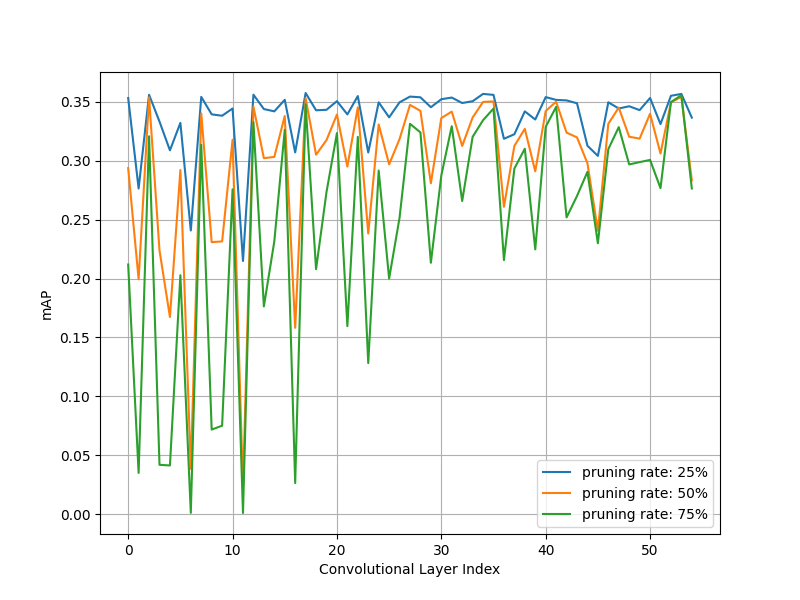

In [20]:
fig0, ax0 = plt.subplots()
hans0 = []
labs0 = []

for idx in range(3):
    hans0.append(plt.plot(layer[idx], precision[idx]))
    labs0.append('pruning rate: '+str((idx+1)*25)+'%')

hans0 = [h[0] for h in hans0]
plt.legend(hans0, labs0)

plt.xlabel('Convolutional Layer Index')
plt.ylabel('mAP')

plt.locator_params(axis='both', nbins=10)
plt.grid(True)
fig0.set_size_inches(8, 6)

### Parameters

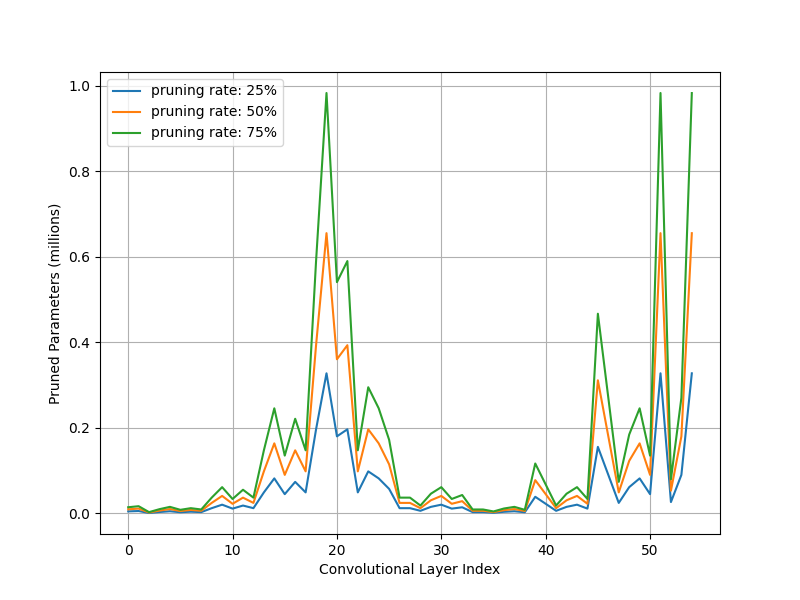

In [21]:
fig1, ax1 = plt.subplots()
hans1 = []
labs1 = []

for idx in range(3):
    hans1.append(plt.plot(layer[idx], [p/1E6 for p in params[idx]]))
    labs1.append('pruning rate: '+str((idx+1)*25)+'%')
    
hans1 = [h[0] for h in hans1]
plt.legend(hans1, labs1)

plt.xlabel('Convolutional Layer Index')
plt.ylabel('Pruned Parameters (millions)')

plt.locator_params(axis='both', nbins=10)
plt.grid(True)
fig1.set_size_inches(8, 6)

In [22]:
params_val = [[] for i in range(3)]
for i in range(3):
    for idx, param in enumerate(params[i]):
        params_val[i].append(param*(precision[i][idx]**10))

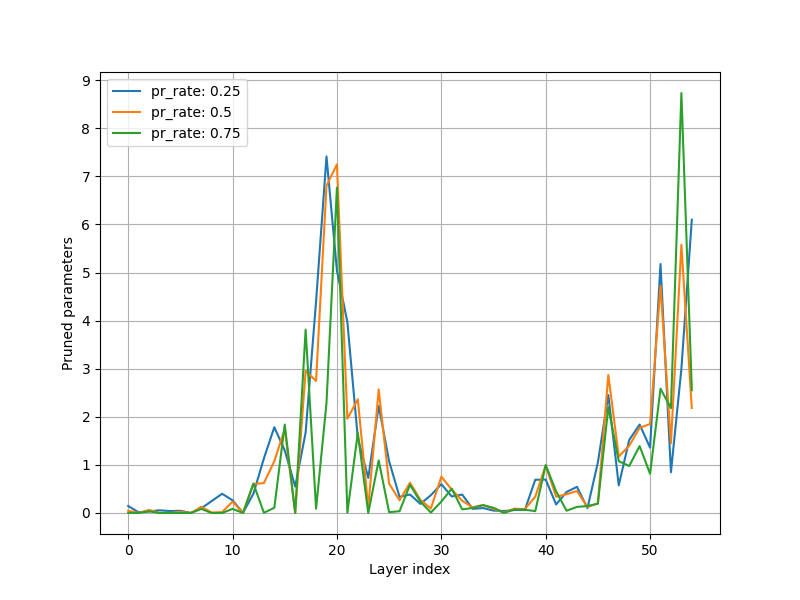

In [23]:
fig, ax = plt.subplots()

for idx in range(3):
    plt.plot(layer[idx], params_val[idx], label='pr_rate: '+str((idx+1)*0.25))
plt.legend()

plt.xlabel('Layer index')
plt.ylabel('Pruned parameters')

plt.locator_params(axis='both', nbins=10)
plt.grid(True)
fig.set_size_inches(8, 6)

In [24]:
max_p = max([max(params_val[i]) for i in range(len(params_val))])
transposed = [list(i) for i in zip(*params_val)]
max_val = [max(transposed[i]) for i in range(len(transposed))]
max_rate = [np.argmax(transposed[i]) for i in range(len(transposed))]
frac = 2
while True:
    number = [max_val.index(val) for val in max_val if val > max_p/frac]           # TODO: find solution for automation
    if len(number) < 2:
        frac+=0.01
    elif len(number) > 4:
        frac-=0.01
    else:
        print(frac)
        break
rate = [max_rate[num] for num in number]
print(number, rate)

1.6799999999999997
[19, 20, 53, 54] [0, 1, 2, 0]


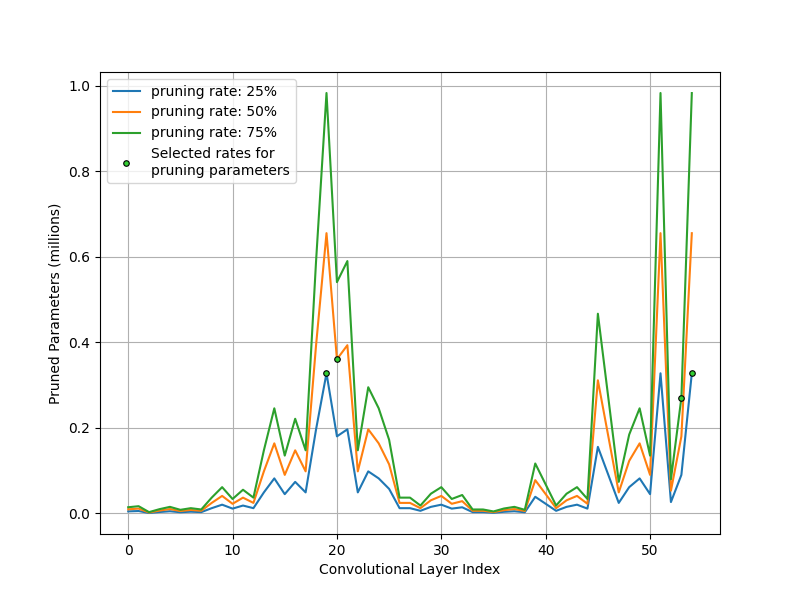

In [25]:
for idx, val in enumerate(number):
    dots = ax1.plot(val, params[rate[idx]][val]/1E6, ".", color='limegreen', ms=8, mec='k', mew=0.8)
hans1.append(dots[0])
labs1.append('Selected rates for\npruning parameters')
ax1.legend(hans1, labs1)
fig1.savefig(output + 'tiny_sa_parameters.pdf', bbox_inches='tight', transparent=True, pad_inches=0)
fig1.show()

### FLOPS

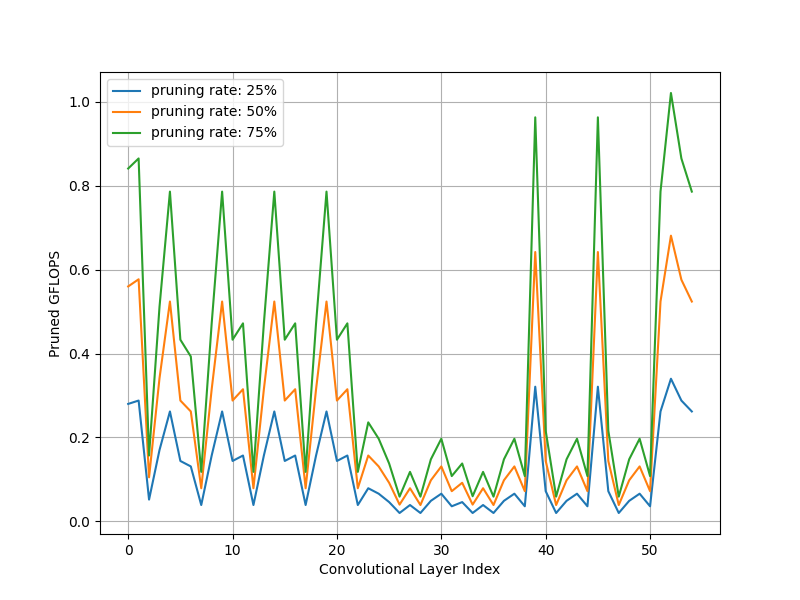

In [26]:
fig2, ax2 = plt.subplots()
hans2 = []
labs2 = []

for idx in range(3):
    hans2.append(plt.plot(layer[idx], flps[idx]))
    labs2.append('pruning rate: '+str((idx+1)*25)+'%')

hans2 = [h[0] for h in hans2]
plt.legend(hans2, labs2)

plt.xlabel('Convolutional Layer Index')
plt.ylabel('Pruned GFLOPS')

plt.locator_params(axis='both', nbins=10)
plt.grid(True)
fig2.set_size_inches(8, 6)

In [27]:
flps_val = [[] for i in range(3)]
for i in range(3):
    for idx, flp in enumerate(flps[i]):
        flps_val[i].append(flp*(precision[i][idx]**10))

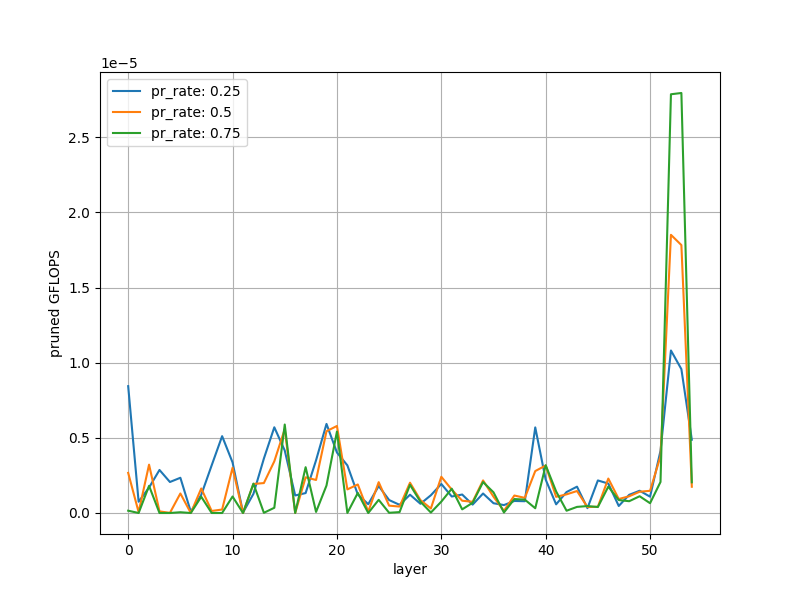

In [28]:
fig, ax = plt.subplots()

for idx in range(3):
    plt.plot(layer[idx], flps_val[idx], label='pr_rate: '+str((idx+1)*0.25))
plt.legend()

plt.xlabel('layer')
plt.ylabel('pruned GFLOPS')

plt.locator_params(axis='both', nbins=10)
plt.grid(True)
fig.set_size_inches(8, 6)

In [29]:
max_p = max([max(flps_val[i]) for i in range(len(flps_val))])
transposed = [list(i) for i in zip(*flps_val)]
max_val = [max(transposed[i]) for i in range(len(transposed))]
max_rate = [np.argmax(transposed[i]) for i in range(len(transposed))]
frac = 2
while True:
    number = [max_val.index(val) for val in max_val if val > max_p/frac]
    if len(number) < 2:
        frac += 0.001
    elif len(number) > 2:
        frac -= 0.001
    else:
        print(frac)
        break
rate = [max_rate[num] for num in number]
print(number, rate)

2
[52, 53] [2, 2]


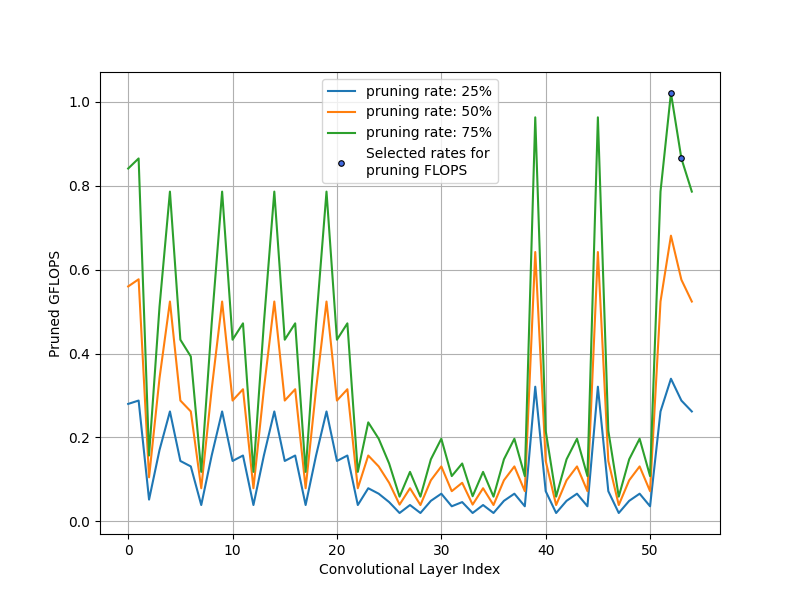

In [30]:
for idx, val in enumerate(number):
    dots = ax2.plot(val, flps[rate[idx]][val], ".", color="royalblue", ms=8, mec='k', mew=0.8)
hans2.append(dots[0])
labs2.append('Selected rates for\npruning FLOPS')
ax2.legend(hans2, labs2)
fig2.savefig(output + 'tiny_sa_flops.pdf', bbox_inches='tight', transparent=True, pad_inches=0)
fig2.show()

### Iterations

In [31]:
it1 = [(8, 0.5), (18, 0.5), (28, 0.75), (29, 0.75), (32, 0.75), (33, 0.75), (41, 0.5), (43, 0.5), (45, 0.5), (46, 0.5)] #20
it1_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'both', 'params', 'params', 'params', 'params', 'params']
it2 = [(1, 0.25), (2, 0.25), (86, 0.75), (87, 0.75), (37, 0.75), (38, 0.75), (39, 0.75), (85, 0.25), (88, 0.25)] #19
it2_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params']
it3 = [(1, 0.25), (7, 0.5), (20, 0.25), (22, 0.5), (40, 0.5), (45, 0.5), (80, 0.25), (83, 0.5), (85, 0.25)] #18
it3_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params']
it4 = [(4, 0.75), (10, 0.25), (26, 0.25), (30, 0.25), (31, 0.5), (35, 0.5), (36, 0.75), (41, 0.5), (78, 0.5)] #18
it4_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'both', 'params', 'params', 'params', 'params', 'params']
it5 = [(12, 0.25), (16, 0.25), (17, 0.25), (18, 0.5), (42, 0.75), (47, 0.5), (79, 0.5), (80, 0.25), (81, 0.25), (85, 0.25)] #18
it5_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params', 'params']
it6 = [(3, 0.25), (6, 0.25), (9, 0.5), (26, 0.25), (54, 0.75), (45, 0.5), (81, 0.25), (82, 0.25), (85, 0.25)] #18
it6_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'both', 'both', 'params', 'params', 'params', 'params']
it7 = [(12, 0.25), (15, 0.25), (16, 0.25), (19, 0.75), (30, 0.25), (27, 0.25), (43, 0.5), (77, 0.5), (85, 0.25), (87, 0.75)] #17
it7_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'both', 'params', 'params', 'params', 'params', 'params']
it8 = [(0, 0.25), (1, 0.25), (22, 0.5), (65, 0.25), (23, 0.5), (26, 0.25), (52, 0.5), (73, 0.5), (81, 0.25), (83, 0.25)] #17
it8_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params', 'params']
it9 = [(0, 0.5), (3, 0.25), (58, 0.5), (69, 0.75), (30, 0.25), (32, 0.75), (33, 0.75), (70, 0.25), (76, 0.75)] #16
it9_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'both', 'params', 'params', 'params', 'params', 'params']
it10 = [(8, 0.5), (12, 0.25), (17, 0.25), (67, 0.75), (40, 0.25), (46, 0.5), (80, 0.25), (82, 0.5), (88, 0.25)] #16
it10_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params']
it11 = [(6, 0.25), (10, 0.25), (63, 0.5), (86, 0.75), (24, 0.5), (25, 0.25), (26, 0.25), (50, 0.75), (84, 0.5), (88, 0.25)] #15
it11_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params', 'params']
it12 = [(14, 0.5), (17, 0.25), (59, 0.75), (60, 0.25), (27, 0.25), (28, 0.75), (34, 0.5), (77, 0.5), (80, 0.5), (88, 0.25)] #15
it12_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params', 'params']
it13 = [(3, 0.25), (12, 0.25), (16, 0.25), (70, 0.25), (30, 0.25), (51, 0.25), (71, 0.25), (72, 0.25), (79, 0.5)] #14
it13_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'both', 'params', 'params', 'params', 'params', 'params']
it14 = [(6, 0.25), (15, 0.25), (16, 0.25), (62, 0.25), (38, 0.75), (40, 0.25), (43, 0.25), (45, 0.25), (75, 0.25), (88, 0.25)] #14
it14_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params', 'params', 'params']

tiny_it1 = [(52, 0.75), (53, 0.75), (19, 0.25), (20, 0.5), (54, 0.25)] #10
tiny_it1_pr = ['FLOPS', 'both', 'params', 'params', 'params']
tiny_it2 = [(0, 0.25), (14, 0.25), (53, 0.75), (18, 0.25), (19, 0.5), (51, 0.25)] #9
tiny_it2_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params']
tiny_it3 = [(9, 0.25), (14, 0.25), (15, 0.5), (17, 0.75), (19, 0.5), (21, 0.25)] #8
tiny_it3_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params']
tiny_it4 = [(0, 0.25), (40, 0.75), (52, 0.75), (24, 0.5), (45, 0.25), (46, 0.25), (51, 0.25)] #8
tiny_it4_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params']
tiny_it5 = [(0, 0.25), (10, 0.5), (34, 0.75), (21, 0.25), (22, 0.5), (49, 0.25)] #8
tiny_it5_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params']
tiny_it6 = [(2, 0.5), (3, 0.25), (5, 0.25), (8, 0.25), (20, 0.75), (46, 0.25), (49, 0.25), (51, 0.25)] #8
tiny_it6_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params']
tiny_it7 = [(3, 0.25), (4, 0.25), (13, 0.25), (14, 0.25), (18, 0.25), (21, 0.25), (49, 0.5), (54, 0.25)] #7
tiny_it7_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params']
tiny_it8 = [(27, 0.5), (30, 0.5), (52, 0.75), (25, 0.25), (46, 0.25), (48, 0.5), (51, 0.25)] #7
tiny_it8_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params']
tiny_it9 = [(12, 0.5), (14, 0.25), (39, 0.5), (24, 0.25), (46, 0.25), (54, 0.25)] #6
tiny_it9_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params']
tiny_it10 = [(5, 0.25), (7, 0.5), (10, 0.5), (18, 0.25), (21, 0.25), (24, 0.25), (54, 0.25)] #6
tiny_it10_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params']
tiny_it11 = [(9, 0.25), (15, 0.5), (37, 0.25), (22, 0.5), (25, 0.25), (46, 0.25), (54, 0.25)] #6
tiny_it11_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params']
tiny_it12 = [(33, 0.75), (37, 0.5), (42, 0.5), (17, 0.75), (18, 0.25), (48, 0.5), (50, 0.5)] #6
tiny_it12_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'params', 'params', 'params', 'params']
tiny_it13 = [(7, 0.5), (12, 0.5), (43, 0.25), (13, 0.25), (24, 0.25), (45, 0.25), (46, 0.25)] #6
tiny_it13_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'both', 'params', 'params', 'params']
tiny_it14 = [(10, 0.5), (37, 0.5), (28, 0.75), (27, 0.5), (19, 0.25), (21, 0.25), (47, 0.5)] #6
tiny_it14_pr = ['FLOPS', 'FLOPS', 'FLOPS', 'both', 'params', 'params', 'params']


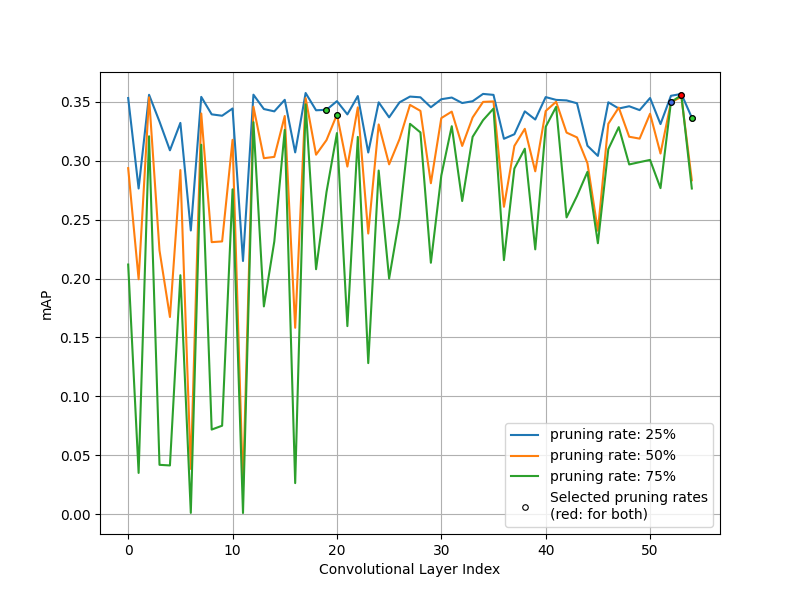

In [32]:
for idx, val in enumerate(tiny_it1):
    h = ax0.plot(val[0], precision[int(val[1]/0.25-1)][val[0]], ".w", ms=8, mec='k', mew=0.8)
    if tiny_it1_pr[idx] == 'FLOPS':
        ax0.plot(val[0], precision[int(val[1]/0.25-1)][val[0]], ".", color='royalblue', ms=8, mec='k', mew=0.8)
    elif tiny_it1_pr[idx] == 'both':
        ax0.plot(val[0], precision[int(val[1]/0.25-1)][val[0]], ".r", ms=8, mec='k', mew=0.8)
    elif tiny_it1_pr[idx] == 'params':
        ax0.plot(val[0], precision[int(val[1]/0.25-1)][val[0]], ".", color='limegreen', ms=8, mec='k', mew=0.8)
hans0.append(h[0])
labs0.append('Selected pruning rates\n(red: for both)')
ax0.legend(hans0, labs0)
fig0.savefig(output + 'tiny_sa_map.pdf', bbox_inches='tight', transparent=True, pad_inches=0)
fig0.show()

# Scatter Plot

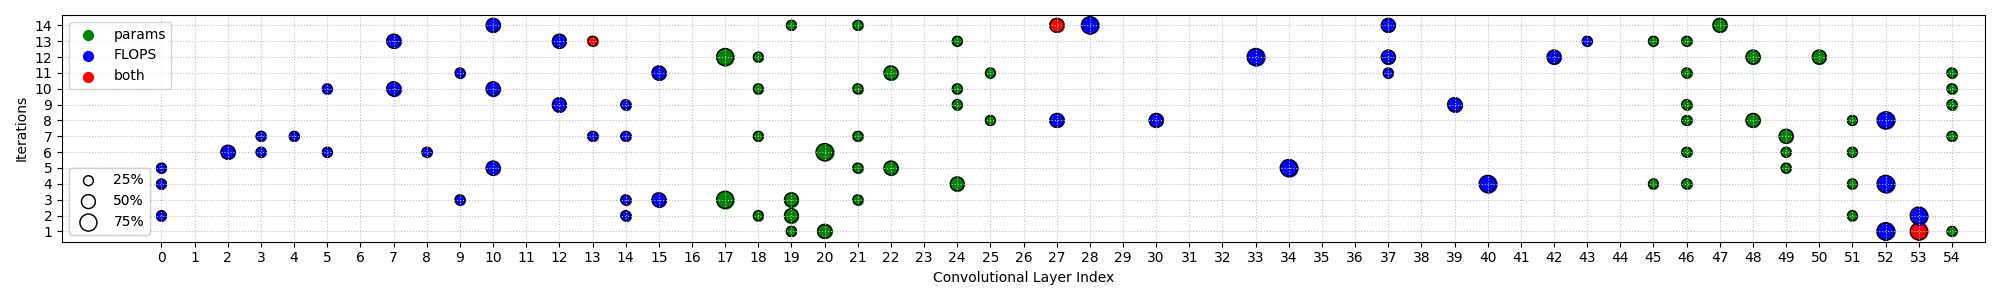

In [33]:
maxlay = 55     # yolo: 89, tiny:55
iter1 = [tiny_it1[idx] + (pr,) for idx, pr in enumerate(tiny_it1_pr)] 
iter2 = [tiny_it2[idx] + (pr,) for idx, pr in enumerate(tiny_it2_pr)] 
iter3 = [tiny_it3[idx] + (pr,) for idx, pr in enumerate(tiny_it3_pr)] 
iter4 = [tiny_it4[idx] + (pr,) for idx, pr in enumerate(tiny_it4_pr)] 
iter5 = [tiny_it5[idx] + (pr,) for idx, pr in enumerate(tiny_it5_pr)] 
iter6 = [tiny_it6[idx] + (pr,) for idx, pr in enumerate(tiny_it6_pr)] 
iter7 = [tiny_it7[idx] + (pr,) for idx, pr in enumerate(tiny_it7_pr)] 
iter8 = [tiny_it8[idx] + (pr,) for idx, pr in enumerate(tiny_it8_pr)]
iter9 = [tiny_it9[idx] + (pr,) for idx, pr in enumerate(tiny_it9_pr)] 
iter10 = [tiny_it10[idx] + (pr,) for idx, pr in enumerate(tiny_it10_pr)]
iter11 = [tiny_it11[idx] + (pr,) for idx, pr in enumerate(tiny_it11_pr)]
iter12 = [tiny_it12[idx] + (pr,) for idx, pr in enumerate(tiny_it12_pr)] 
iter13 = [tiny_it13[idx] + (pr,) for idx, pr in enumerate(tiny_it13_pr)]
iter14 = [tiny_it14[idx] + (pr,) for idx, pr in enumerate(tiny_it14_pr)]

iters = {'1': iter1, '2': iter2, '3': iter3, '4': iter4, '5': iter5, '6': iter6, '7': iter7, '8': iter8, '9': iter9,
         '10': iter10, '11': iter11, '12': iter12, '13': iter13, '14': iter14}
colors = {'FLOPS': 'b', 'both': 'r', 'params': 'g'}
size = 200
c=[]
c_label = []
s=[]
s_label = []

fig, ax = plt.subplots()
for idx, it in enumerate(iters.keys()):
    layers = iters[it]
    for layer in layers:
        if layer[2] not in c_label:
            c_label.append(layer[2])
            c.append(plt.scatter(layer[0], it, s=0.25*size, c=colors[layer[2]]))
        if layer[1] not in s_label:
            s_label.append(layer[1])
            s.append(plt.scatter(layer[0], it, s=layer[1]*size, facecolors='none', edgecolors='k'))
        plt.scatter(layer[0], it, s=layer[1]*size, c=colors[layer[2]])
        plt.scatter(layer[0], it, s=layer[1]*size, facecolors='none', edgecolors='k')

s_dict = dict(sorted({str(int(sl*100)) + '%': s[idx] for idx, sl in enumerate(s_label)}.items()))
c_dict = dict(sorted({cl: c[idx] for idx, cl in enumerate(c_label)}.items(), key=lambda item: item[0].lower(), reverse=True))
legend1 = plt.legend(c_dict.values(), c_dict.keys(), loc="upper left")
legend2 = plt.legend(s_dict.values(), s_dict.keys(), loc="lower left")
ax.add_artist(legend1)
ax.add_artist(legend2)

ax.set_xticks(np.arange(0, maxlay, 1))
ax.set_xlim(-3, maxlay)
plt.xlabel('Convolutional Layer Index')
plt.ylabel('Iterations')
plt.grid(axis='both', linestyle='dotted', color='silver')
fig.set_size_inches(20, 3)
plt.tight_layout()
plt.savefig(output + 'tiny_layers.pdf')

# AP vs Sparsity

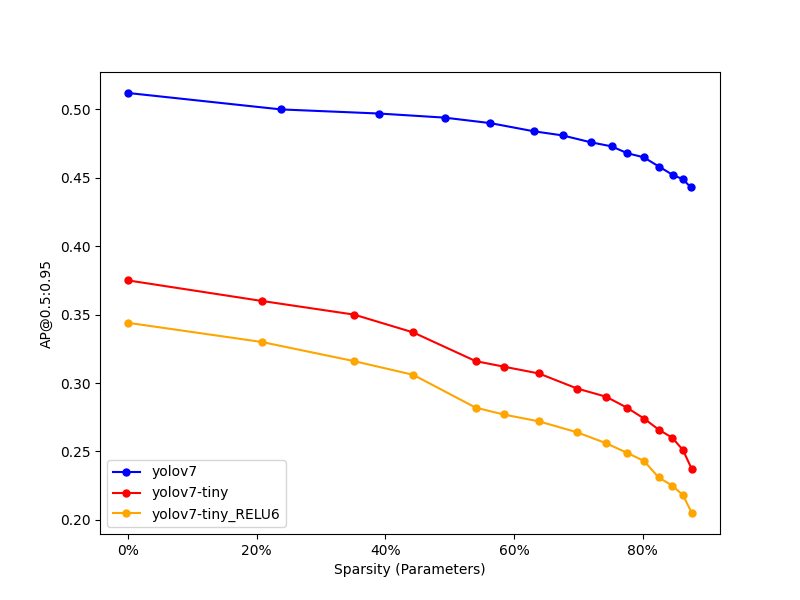

In [34]:

fig, ax = plt.subplots()
j = 0
prms_list = []
aps_list = []
prmst_list = []
apst_list = []
for i in range(len(aps)):
    if not i%2:
        prms_list.append(per_params[j])
        aps_list.append(aps[i])
        prmst_list.append(per_params_t[j])
        apst_list.append(aps_t[i])
        j += 1
plt.plot(prms_list, aps_list, 'b', marker='o', ms=5, label='yolov7')
plt.plot(prmst_list, apst_list, 'r', marker='o', ms=5, label='yolov7-tiny')
plt.plot(prmst_list[:len(mod_aps)], mod_aps, 'orange', marker='o', ms=5, label='yolov7-tiny_RELU6')
plt.legend()
plt.xlabel('Sparsity (Parameters)')
plt.ylabel('AP@0.5:0.95')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
fig.set_size_inches(8, 6)
plt.savefig(output + 'ap_vs_parameters.pdf')

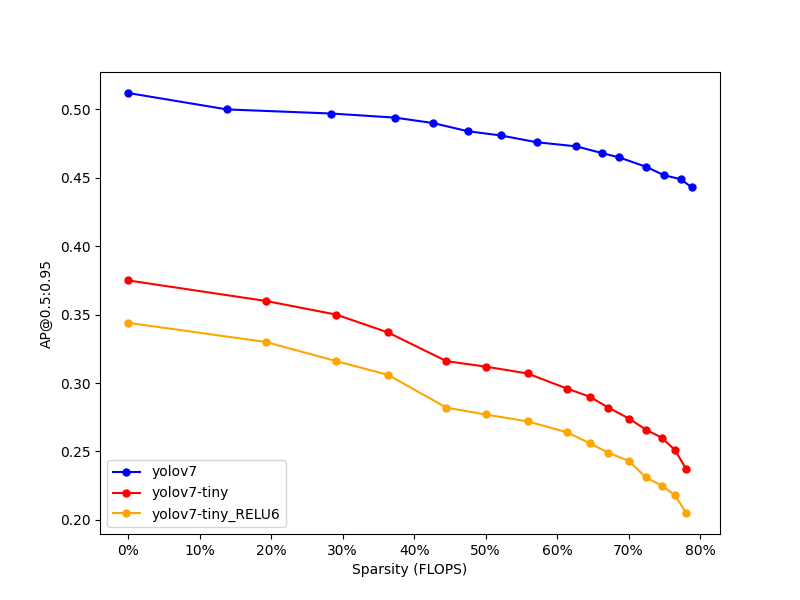

In [35]:
fig, ax = plt.subplots()
j = 0
flps_list = []
aps_list = []
flpst_list = []
apst_list = []
for i in range(len(aps)):
    if not i%2:
        flps_list.append(per_flops[j])
        aps_list.append(aps[i])
        flpst_list.append(per_flops_t[j])
        apst_list.append(aps_t[i])
        j += 1
plt.plot(flps_list, aps_list, 'b', marker='o', ms=5, label='yolov7')
plt.plot(flpst_list, apst_list, 'r', marker='o', ms=5, label='yolov7-tiny')
plt.plot(flpst_list[:len(mod_aps)], mod_aps, 'orange', marker='o', ms=5, label='yolov7-tiny_RELU6')
plt.legend()
plt.xlabel('Sparsity (FLOPS)')
plt.ylabel('AP@0.5:0.95')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
fig.set_size_inches(8, 6)
plt.savefig(output + 'ap_vs_flops.pdf')

# Results Plot


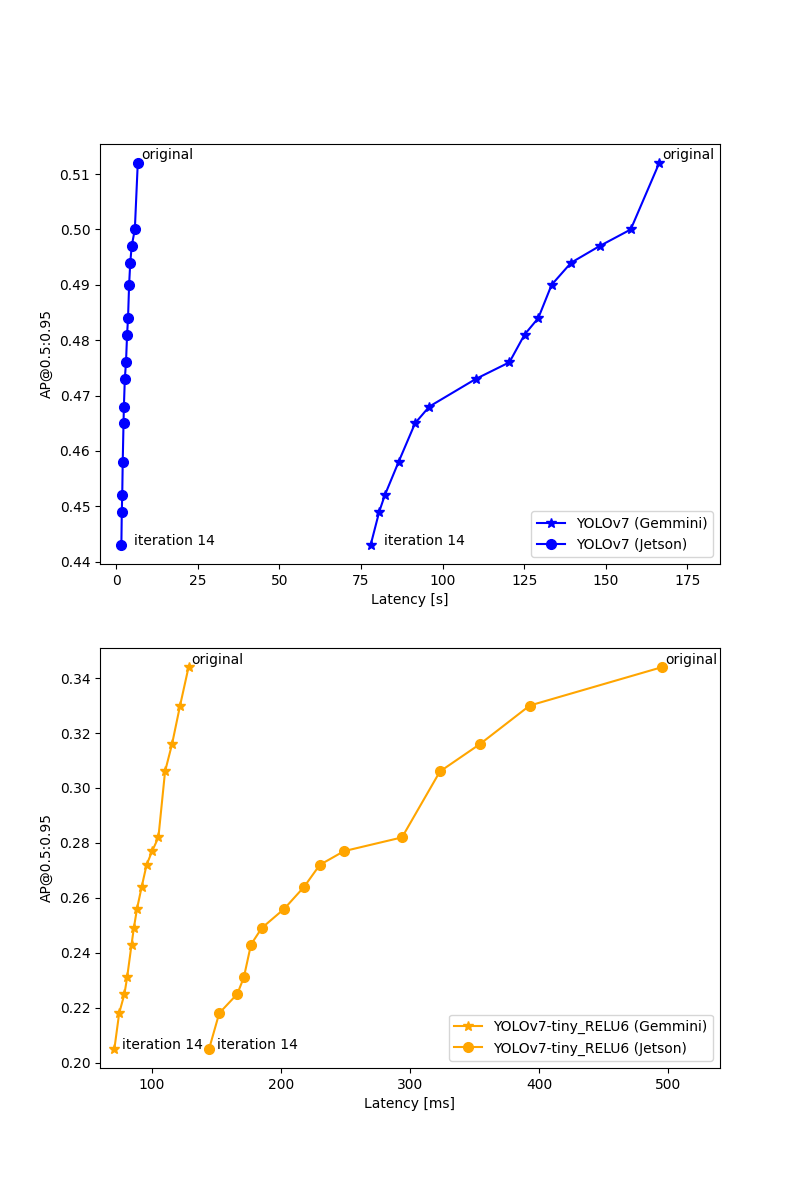

In [37]:
file = '../results_v2.ods'
rs = pd.ExcelFile(file, engine='odf')
fig, ax = plt.subplots(2, 1)
for i in range(len(aps)):
    if not i%2:
        aps_list.append(aps[i])

for i in range(2):
    result = pd.read_excel(file, engine='odf', sheet_name=rs.sheet_names[i])
    models = [model for model in result['Model'].astype("string")]
    latency= []
    for l in result['Latency all [ms]']: 
        if not l:
            break
        latency.append(l)
    device = result['Device'].astype("string")[0]
    m = 'o' if i else '*'
    latency[15:] = [l/1000 for l in latency[15:]]
    ax[0].plot(latency[15:], aps_list[:15], 'b', marker=m, ms=7, label=f'YOLOv7 ({device})')
    ax[0].annotate("original", xy=(latency[15]+1, aps_list[0]+0.0008))
    ax[0].annotate("iteration 14", xy=(latency[-1]+4, aps_list[14]))
    ax[1].plot(latency[:15], mod_aps[:15], 'orange', marker=m, ms=7, label=f'YOLOv7-tiny_RELU6 ({device})')
    ax[1].annotate("original", xy=(latency[0]+2, mod_aps[0]+0.001))
    ax[1].annotate("iteration 14", xy=(latency[14]+6, mod_aps[14]))
    
ax[0].legend()
ax[0].set_xlabel('Latency [s]')
ax[0].set_ylabel('AP@0.5:0.95')
ax[0].set_xlim(-5, 185)

ax[1].legend()
ax[1].set_xlabel('Latency [ms]')
ax[1].set_ylabel('AP@0.5:0.95')
ax[1].set_xlim(60, 540)
fig.set_size_inches(8, 12)
plt.savefig(output + 'ap_vs_speed.pdf')

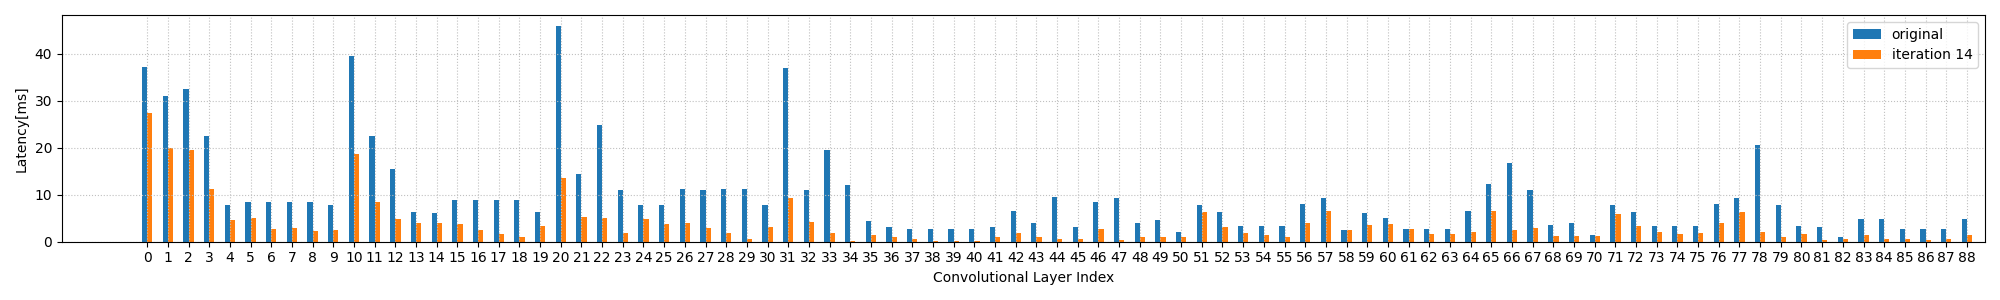

In [38]:
file = '../results_v2.ods'
sheets = ['Yolov7-0', 'Yolov7-14']
latency = {}
for sheet in sheets:
    result = pd.read_excel(file, engine='odf', sheet_name=sheet)
    latency[sheet] = {}
    convs = result['Only conv2d']
    for idx, val in enumerate(result['Node']):
        node = str(val).split('_')
        if 'conv2d' in node:
            layer = 0 if node[-1] == 'conv2d' else int(node[-1])
            latency[sheet][layer] = convs[idx]/1000
    latency[sheet] = dict(sorted(latency[sheet].items())[:-3])

fig, ax = plt.subplots()
length = len(latency[sheets[0]])
r = np.arange(length) 
width = 0.25
plt.bar(r, latency[sheets[0]].values(), width=width, label = 'original') 
plt.bar(r + width, latency[sheets[1]].values(), width=width, label = 'iteration 14')
plt.xticks(r + width/2,latency[sheets[0]].keys()) 
plt.xlim(-4, length)
plt.legend()
plt.xlabel('Convolutional Layer Index')
plt.ylabel('Latency[ms]')
plt.grid(axis='both', linestyle='dotted', color='silver')
fig.set_size_inches(20, 3)
plt.tight_layout()
plt.savefig(output + 'yolo_latency_per_layer.pdf')

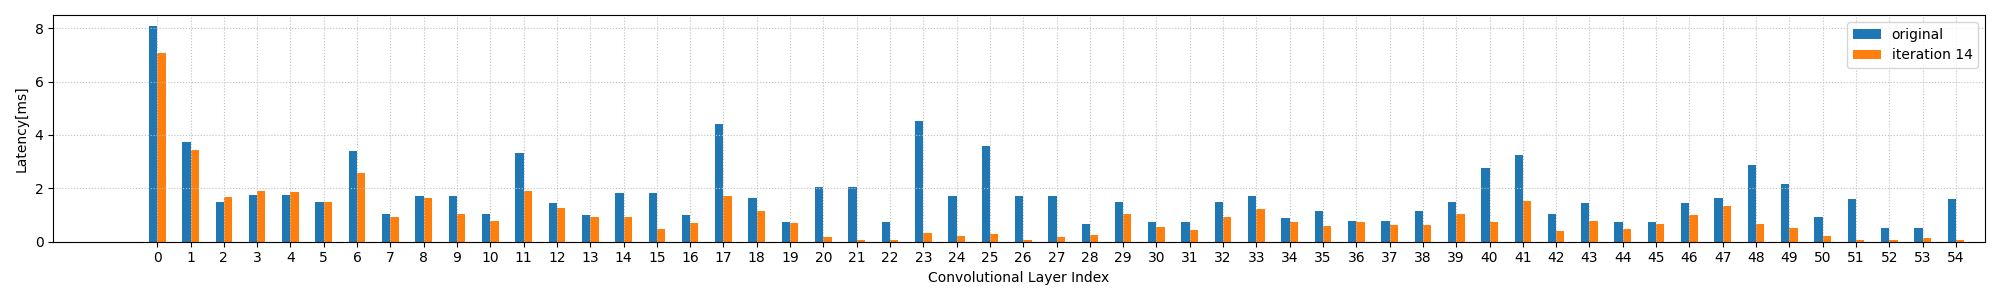

In [39]:
file = '../results_v2.ods'
sheets = ['Yolov7-tiny-0', 'Yolov7-tiny-14']
latency = {}
for sheet in sheets:
    result = pd.read_excel(file, engine='odf', sheet_name=sheet)
    latency[sheet] = {}
    convs = result['Only conv2d']
    for idx, val in enumerate(result['Node']):
        node = str(val).split('_')
        if 'conv2d' in node:
            layer = 0 if node[-1] == 'conv2d' else int(node[-1])
            latency[sheet][layer] = convs[idx]/1000
    latency[sheet] = dict(sorted(latency[sheet].items())[:-3])

fig, ax = plt.subplots()
length = len(latency[sheets[0]])
r = np.arange(length) 
width = 0.25
plt.bar(r, latency[sheets[0]].values(), width=width, label = 'original') 
plt.bar(r + width, latency[sheets[1]].values(), width=width, label = 'iteration 14')
plt.xticks(r + width/2,latency[sheets[0]].keys()) 
plt.xlim(-3, length)
plt.legend()
plt.xlabel('Convolutional Layer Index')
plt.ylabel('Latency[ms]')
plt.grid(axis='both', linestyle='dotted', color='silver')
fig.set_size_inches(20, 3)
plt.tight_layout()
plt.savefig(output + 'tiny_latency_per_layer.pdf')

# Parmeters / FLOPS per layer

In [49]:
def cln(line):
    char = '() []'
    a = []
    lis = line.split(',')
    lis.pop()
    for i in range(len(lis)):
        for c in char:
            lis[i] = lis[i].replace(c, '')
        if lis[i]:
            a.append(float(lis[i]))
    return a
pyolo = '[[[896.0, []], [18496.0, []], [36928.0, []], [73856.0, []], [8256.0, []], [8256.0, []], [36928.0, []], [36928.0, []], [36928.0, []], [36928.0, []], [], [65792.0, []], [0.0], [32896.0, []], [32896.0, []], [147584.0, []], [], [32896.0, []], [32896.0, []], [147584.0, []], [147584.0, []], [147584.0, []], [147584.0, []], [], [262656.0, []], [0.0], [131328.0, []], [131328.0, []], [590080.0, []], [], [131328.0, []], [131328.0, []], [590080.0, []], [590080.0, []], [590080.0, []], [590080.0, []], [], [1049600.0, []], [0.0], [524800.0, []], [524800.0, []], [2359808.0, []], [], [262400.0, []], [262400.0, []], [590080.0, []], [590080.0, []], [590080.0, []], [590080.0, []], [], [1049600.0, []], [[524800.0, []], [524800.0, []], [2359808.0, []], [262656.0, []], [0.0, 0.0, 0.0], [1049088.0, []], [2359808.0, []], [524800.0, []]], [131328.0, []], 0.0, [262400.0, []], [], [131328.0, []], [131328.0, []], [295040.0, []], [147584.0, []], [147584.0, []], [147584.0, []], [], [262400.0, []], [32896.0, []], 0.0, [65664.0, []], [], [32896.0, []], [32896.0, []], [73792.0, []], [36928.0, []], [36928.0, []], [36928.0, []], [], [65664.0, []], [0.0], [16512.0, []], [16512.0, []], [147584.0, []], [], [131328.0, []], [131328.0, []], [295040.0, []], [147584.0, []], [147584.0, []], [147584.0, []], [], [262400.0, []], [0.0], [65792.0, []], [65792.0, []], [590080.0, []], [], [524800.0, []], [524800.0, []], [1179904.0, []], [590080.0, []], [590080.0, []], [590080.0, []], [], [1049088.0, []], [[], 295168.0], [[], 1180160.0], [[], 4719616.0], [[65535.0, 130815.0, 261375.0]]]]'
oyolo = '[[[884736.0, []], [4718592.0, []], [9437184.0, []], [4718592.0, []], [524288.0, []], [524288.0, []], [2359296.0, []], [2359296.0, []], [2359296.0, []], [2359296.0, []], [], [4194304.0, []], [0.0], [524288.0, []], [2097152.0, []], [2359296.0, []], [], [524288.0, []], [524288.0, []], [2359296.0, []], [2359296.0, []], [2359296.0, []], [2359296.0, []], [], [4194304.0, []], [0.0], [524288.0, []], [2097152.0, []], [2359296.0, []], [], [524288.0, []], [524288.0, []], [2359296.0, []], [2359296.0, []], [2359296.0, []], [2359296.0, []], [], [4194304.0, []], [0.0], [524288.0, []], [2097152.0, []], [2359296.0, []], [], [262144.0, []], [262144.0, []], [589824.0, []], [589824.0, []], [589824.0, []], [589824.0, []], [], [1048576.0, []], [[524288.0, []], [524288.0, []], [2359296.0, []], [262144.0, []], [0.0, 0.0, 0.0], [1048576.0, []], [2359296.0, []], [524288.0, []]], [131072.0, []], 1024.0, [1048576.0, []], [], [524288.0, []], [524288.0, []], [1179648.0, []], [589824.0, []], [589824.0, []], [589824.0, []], [], [1048576.0, []], [131072.0, []], 2048.0, [1048576.0, []], [], [524288.0, []], [524288.0, []], [1179648.0, []], [589824.0, []], [589824.0, []], [589824.0, []], [], [1048576.0, []], [0.0], [65536.0, []], [262144.0, []], [589824.0, []], [], [524288.0, []], [524288.0, []], [1179648.0, []], [589824.0, []], [589824.0, []], [589824.0, []], [], [1048576.0, []], [0.0], [65536.0, []], [262144.0, []], [589824.0, []], [], [524288.0, []], [524288.0, []], [1179648.0, []], [589824.0, []], [589824.0, []], [589824.0, []], [], [1048576.0, []], [[], 4718592.0], [[], 4718592.0], [[], 4718592.0], [[1044480.0, 522240.0, 261120.0]]]]'
ptiny = '[[[896.0, 0.0], [18496.0, 0.0], [2080.0, 0.0], [2080.0, 0.0], [9248.0, 0.0], [9248.0, 0.0], [], [8256.0, 0.0], [0.0], [4160.0, 0.0], [4160.0, 0.0], [36928.0, 0.0], [36928.0, 0.0], [], [32896.0, 0.0], [0.0], [16512.0, 0.0], [16512.0, 0.0], [147584.0, 0.0], [147584.0, 0.0], [], [131328.0, 0.0], [0.0], [65792.0, 0.0], [65792.0, 0.0], [590080.0, 0.0], [590080.0, 0.0], [], [524800.0, 0.0], [131328.0, 0.0], [131328.0, 0.0], [0.0], [0.0], [0.0], [], [262400.0, 0.0], [], [131328.0, 0.0], [32896.0, 0.0], 0.0, [32896.0, 0.0], [], [16448.0, 0.0], [16448.0, 0.0], [36928.0, 0.0], [36928.0, 0.0], [], [32896.0, 0.0], [8256.0, 0.0], 0.0, [8256.0, 0.0], [], [4128.0, 0.0], [4128.0, 0.0], [9248.0, 0.0], [9248.0, 0.0], [], [8256.0, 0.0], [73856.0, 0.0], [], [16448.0, 0.0], [16448.0, 0.0], [36928.0, 0.0], [36928.0, 0.0], [], [32896.0, 0.0], [295168.0, 0.0], [], [65664.0, 0.0], [65664.0, 0.0], [147584.0, 0.0], [147584.0, 0.0], [], [131328.0, 0.0], [73856.0, 0.0], [295168.0, 0.0], [1180160.0, 0.0], [[32895.0, 65535.0, 130815.0]]]]'
otiny = '[[[221184.0, 0.0], [1179648.0, 0.0], [131072.0, 0.0], [131072.0, 0.0], [589824.0, 0.0], [589824.0, 0.0], [], [524288.0, 0.0], [0.0], [65536.0, 0.0], [65536.0, 0.0], [589824.0, 0.0], [589824.0, 0.0], [], [524288.0, 0.0], [0.0], [65536.0, 0.0], [65536.0, 0.0], [589824.0, 0.0], [589824.0, 0.0], [], [524288.0, 0.0], [0.0], [65536.0, 0.0], [65536.0, 0.0], [589824.0, 0.0], [589824.0, 0.0], [], [524288.0, 0.0], [131072.0, 0.0], [131072.0, 0.0], [0.0], [0.0], [0.0], [], [262144.0, 0.0], [], [131072.0, 0.0], [32768.0, 0.0], 512.0, [131072.0, 0.0], [], [65536.0, 0.0], [65536.0, 0.0], [147456.0, 0.0], [147456.0, 0.0], [], [131072.0, 0.0], [32768.0, 0.0], 1024.0, [131072.0, 0.0], [], [65536.0, 0.0], [65536.0, 0.0], [147456.0, 0.0], [147456.0, 0.0], [], [131072.0, 0.0], [294912.0, 0.0], [], [65536.0, 0.0], [65536.0, 0.0], [147456.0, 0.0], [147456.0, 0.0], [], [131072.0, 0.0], [294912.0, 0.0], [], [65536.0, 0.0], [65536.0, 0.0], [147456.0, 0.0], [147456.0, 0.0], [], [131072.0, 0.0], [1179648.0, 0.0], [1179648.0, 0.0], [1179648.0, 0.0], [[522240.0, 261120.0, 130560.0]]]]'

120


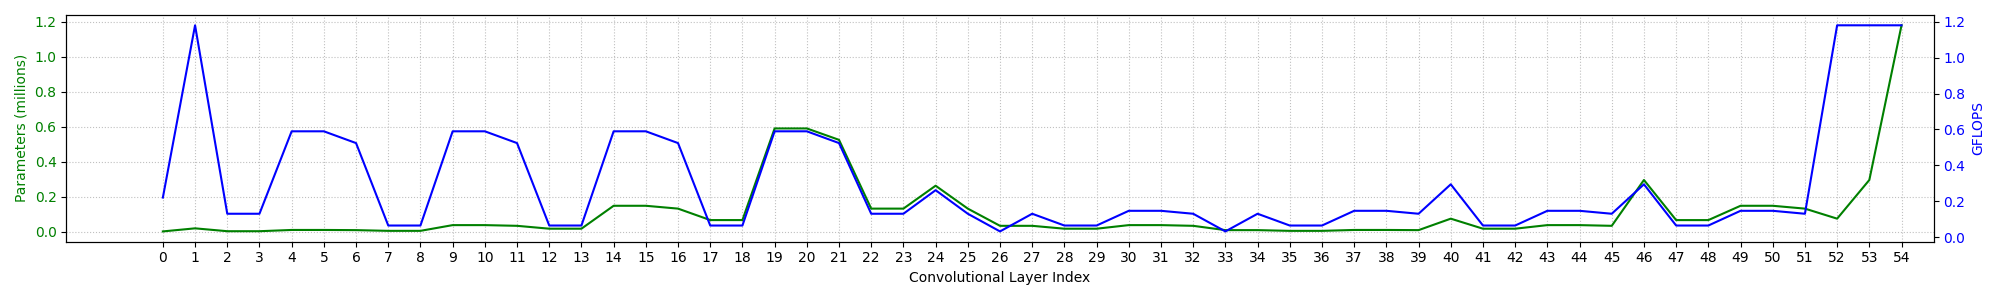

In [51]:
plist = cln(ptiny)
olist = cln(otiny)
length = 55   # yolo:90   tiny:55

fig, ax1 = plt.subplots()
ps = []
os = []
for p, o in zip(plist, olist):
    if p>0 and len(ps)<length:
        ps.append(p)
        os.append(o)
ps = [p/1E6 for p in ps]
os = [o/1E6 for o in os]

color1 = 'green'
name1 = 'Parameters (millions)'
color2 = 'blue'
name2 = 'GFLOPS'
ax1.plot(ps, color=color1)
ax1.set_xlabel('Convolutional Layer Index')
ax1.set_ylabel(name1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
plt.grid(axis='both', linestyle='dotted', color='silver')
fig.set_size_inches(20, 3)

ax2 = ax1.twinx()
ax2.plot(os, color=color2)
ax2.set_ylabel(name2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.xticks(np.arange(0, length, 1))
plt.xlim(-3, length)
plt.tight_layout()
fig.savefig(output + 'tiny_both_per_layer.pdf')